In [116]:
# PART 1: Spark aggregation to state-year (weighted rates/means)
from pyspark.sql import SparkSession, functions as F
from pathlib import Path

BASE = "/Users/compiling/435Project/Project"
COMPLETE_DIR = Path(BASE) / "complete"

spark = SparkSession.builder.appName("MicroAggregateForSklearn").getOrCreate()

micro = spark.read.parquet(str(COMPLETE_DIR / "pums_*.parquet"))
print("Total micro rows (all years):", micro.count())

weight_col = 'PWGTP'
group_cols = ['STATE_NAME', 'YEAR']
wt_sum = F.sum(weight_col)

features = [
    wt_sum.alias('state_year_population'),
    F.first('TOTAL_HEALTH_SPENDING').alias('TOTAL_HEALTH_SPENDING'),
    (F.sum(F.when(F.col('AGEP') >= 65, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_65plus_share'),
    (F.sum(F.when(F.col('AGEP') <= 17, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_0_17_share'),
    (F.sum(F.when(F.col('HICOV') == 2, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HICOV_uninsured_share'),
    (F.sum(F.when(F.col('HINS1') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS1_employer_share'),
    (F.sum(F.when(F.col('HINS4') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS4_medicaid_share'),
    (F.sum(F.col('PINCP') * F.col(weight_col)) / wt_sum).alias('PINCP_mean'),
    (F.sum(F.when(F.col('POVPIP') < 138, F.col(weight_col)).otherwise(0)) / wt_sum).alias('POVPIP_poverty_share'),
    (F.sum(F.col('VEH') * F.col(weight_col)) / wt_sum).alias('VEH_mean'),
    (F.sum(F.when(F.col('BROADBND') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('BROADBND_yes_share'),
]

print("Aggregating microdata to state-year panel ...")
df_state_year = (
    micro
    .groupBy(*group_cols)
    .agg(*features)
    .toPandas()
)
print('Final panel shape:', df_state_year.shape)
df_state_year.head()


25/12/01 14:25:27 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: /Users/compiling/435Project/Project/complete/pums_*.parquet.
java.io.FileNotFoundException: File /Users/compiling/435Project/Project/complete/pums_*.parquet does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(Resol

Total micro rows (all years): 15912393
Aggregating microdata to state-year panel ...
Final panel shape: (255, 13)


,STATE_NAME,YEAR,state_year_population,TOTAL_HEALTH_SPENDING,AGEP_65plus_share,AGEP_0_17_share,HICOV_uninsured_share,HINS1_employer_share,HINS4_medicaid_share,PINCP_mean,POVPIP_poverty_share,VEH_mean,BROADBND_yes_share
0,Georgia,2023,11029227,7984.0,0.153987,0.229787,0.118536,0.522321,0.188935,38810.499869,0.191753,2.146883,0.882308
1,New Jersey,2023,9290841,9676.0,0.177698,0.216073,0.071422,0.598993,0.191311,51615.316750,0.137178,1.919621,0.902386
2,Minnesota,2021,5707390,8686.0,0.168798,0.228722,0.043775,0.609255,0.188332,40836.982569,0.131647,2.168501,0.875737
3,Kansas,2023,2940547,8502.0,0.176232,0.233088,0.083518,0.573489,0.149897,37804.513519,0.166826,2.234180,0.865346
4,Utah,2021,3337975,5734.0,0.116340,0.282819,0.093118,0.633758,0.111642,34442.641509,0.127119,2.513679,0.897629


In [117]:
# PART 2: Pooled RF model (per-capita target, shuffled split)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Verify target uniqueness per state-year
leakage_counts = df_state_year.groupby(['STATE_NAME', 'YEAR'])['TOTAL_HEALTH_SPENDING'].nunique()
print('Target nunique per state-year:')
print(leakage_counts.value_counts().sort_index())
print('Summary:')
print(leakage_counts.describe())

target = 'TOTAL_HEALTH_SPENDING'  # per-capita dollars
categorical_cols = []  # drop STATE_NAME for pooled drivers
numeric_cols = [c for c in df_state_year.columns if c not in {target, 'STATE_NAME', 'ST', 'state_year_population'}]

X = df_state_year[categorical_cols + numeric_cols]
y = df_state_year[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(f'Training on {len(X_train)} samples, Testing on {len(X_test)} samples')

preprocess = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
])

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    n_jobs=-1,
    random_state=42,
)

pipe = Pipeline([('pre', preprocess), ('rf', rf)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test R^2 : {r2:,.3f}')
print(f'Test MAE : {mae:,.2f}')
print(f'Test RMSE: {rmse:,.2f}')


Target nunique per state-year:
TOTAL_HEALTH_SPENDING
1    255
Name: count, dtype: int64
Summary:
count    255.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: TOTAL_HEALTH_SPENDING, dtype: float64
Training on 204 samples, Testing on 51 samples
Test R^2 : 0.636
Test MAE : 670.05
Test RMSE: 881.36


In [126]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/zy/dcp74d8d6rn7pyyg_ghpdb700000gn/T/ipykernel_54291/300427722.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


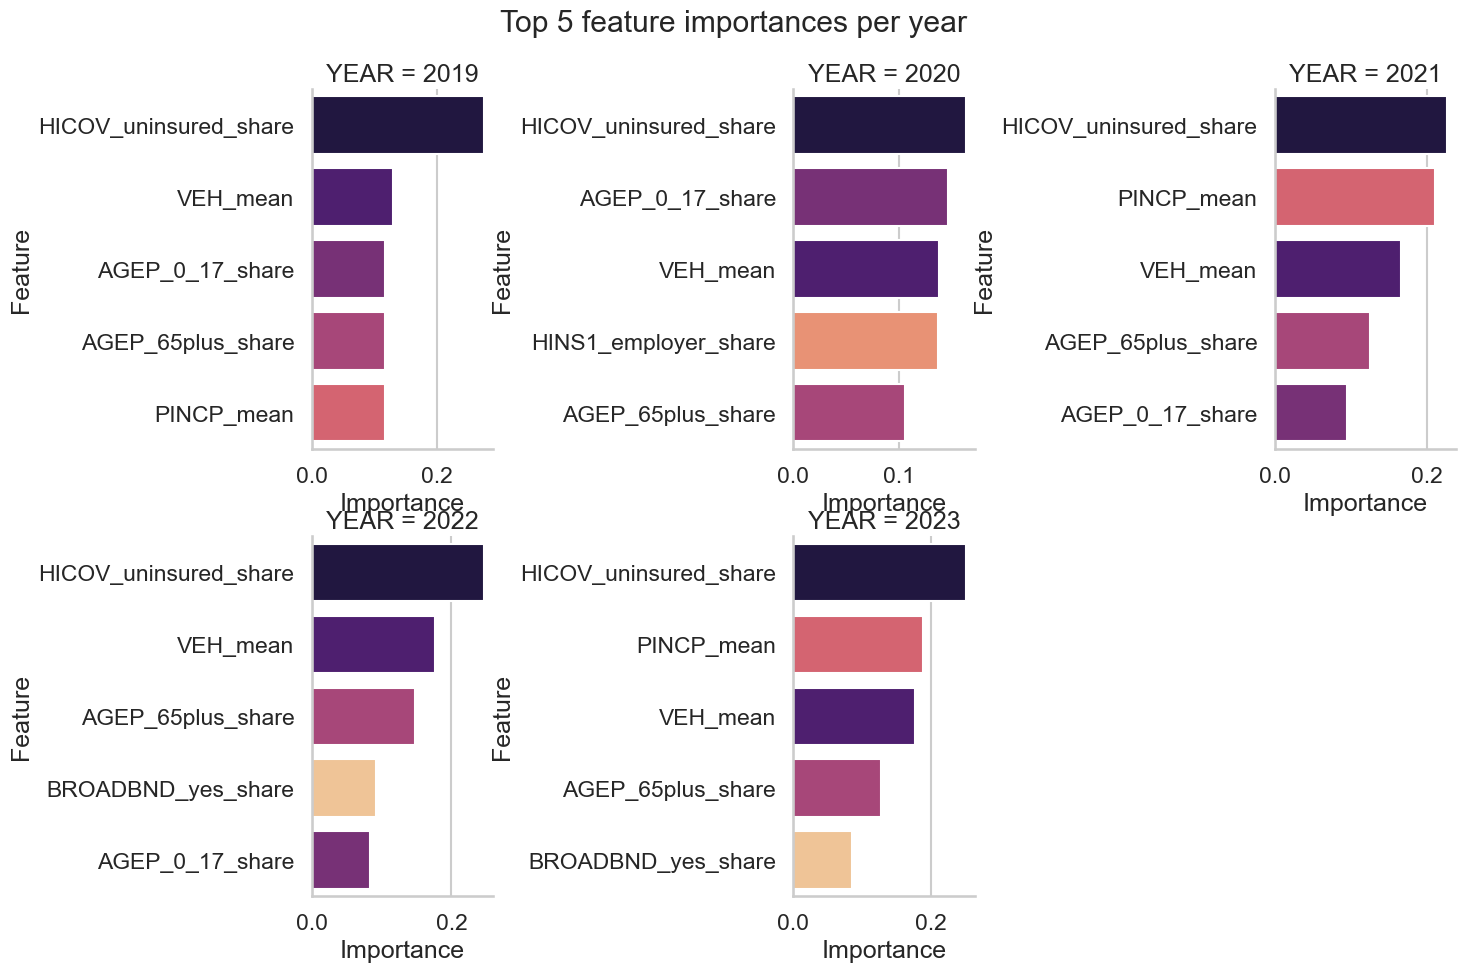

In [127]:
sns.set_theme(style="whitegrid", context="talk")

feature_cols_year = [c for c in df_state_year.columns if c not in {target, 'STATE_NAME', 'ST', 'state_year_population', 'YEAR'}]
records = []
for y in sorted(df_state_year['YEAR'].unique()):
    df_y = df_state_year[df_state_year['YEAR'] == y]
    X_y = df_y[feature_cols_year]
    y_y = df_y[target]
    rf_y = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_leaf=2, n_jobs=-1, random_state=42)
    rf_y.fit(X_y, y_y)
    fi = pd.DataFrame({'feature': feature_cols_year, 'importance': rf_y.feature_importances_}).sort_values('importance', ascending=False).head(5)
    fi['YEAR'] = y
    records.append(fi)

df_imp = pd.concat(records, ignore_index=True)

g = sns.catplot(
    data=df_imp,
    x='importance', y='feature', col='YEAR', kind='bar',
    palette='magma', sharex=False, sharey=False, col_wrap=3,
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Top 5 feature importances per year')
for ax in g.axes.flatten():
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')
plt.show()


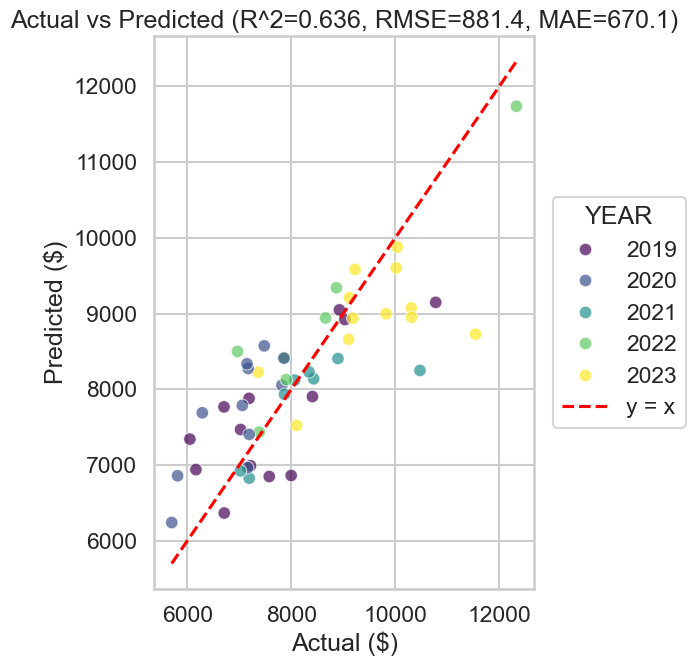

In [121]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
sns.set_theme(style="whitegrid", context="talk")
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred,
                hue=X_test['YEAR'] if 'YEAR' in X_test else None,
                palette='viridis', alpha=0.7)
lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual ($)')
plt.ylabel('Predicted ($)')
plt.title(f'Actual vs Predicted (R^2={r2:.3f}, RMSE={rmse:,.1f}, MAE={mae:,.1f})')
plt.legend(title='YEAR', bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.tight_layout()
plt.show()


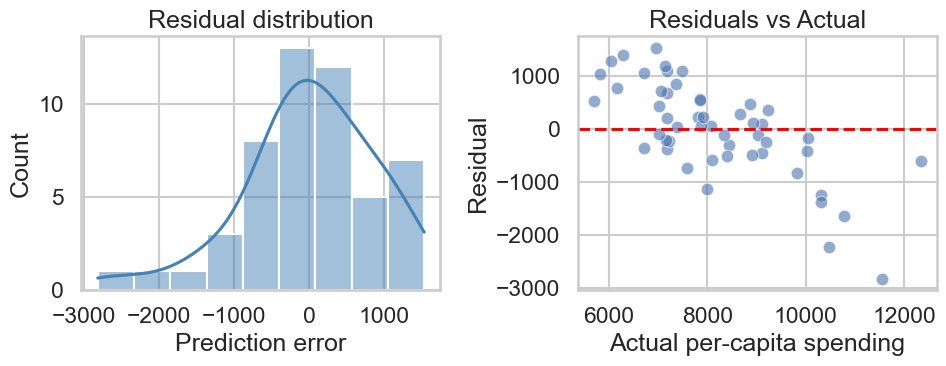

In [122]:
sns.set_theme(style="whitegrid", context="talk")
residuals = y_pred - y_test
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(residuals, kde=True, color='steelblue')
plt.title('Residual distribution')
plt.xlabel('Prediction error')
plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Actual')
plt.xlabel('Actual per-capita spending')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()


/var/folders/zy/dcp74d8d6rn7pyyg_ghpdb700000gn/T/ipykernel_54291/3775905976.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_overall.head(10), x='importance', y='feature', palette='magma')


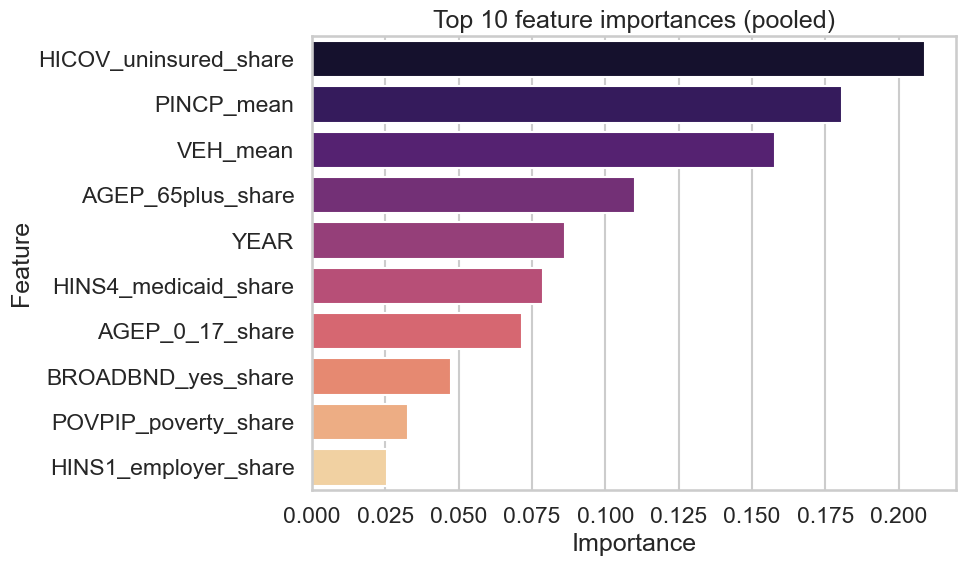

In [123]:
sns.set_theme(style="whitegrid", context="talk")
fi_overall = (
    pd.DataFrame({'feature': numeric_cols, 'importance': pipe.named_steps['rf'].feature_importances_})
    .sort_values('importance', ascending=False)
)
plt.figure(figsize=(10,6))
sns.barplot(data=fi_overall.head(10), x='importance', y='feature', palette='magma')
plt.title('Top 10 feature importances (pooled)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


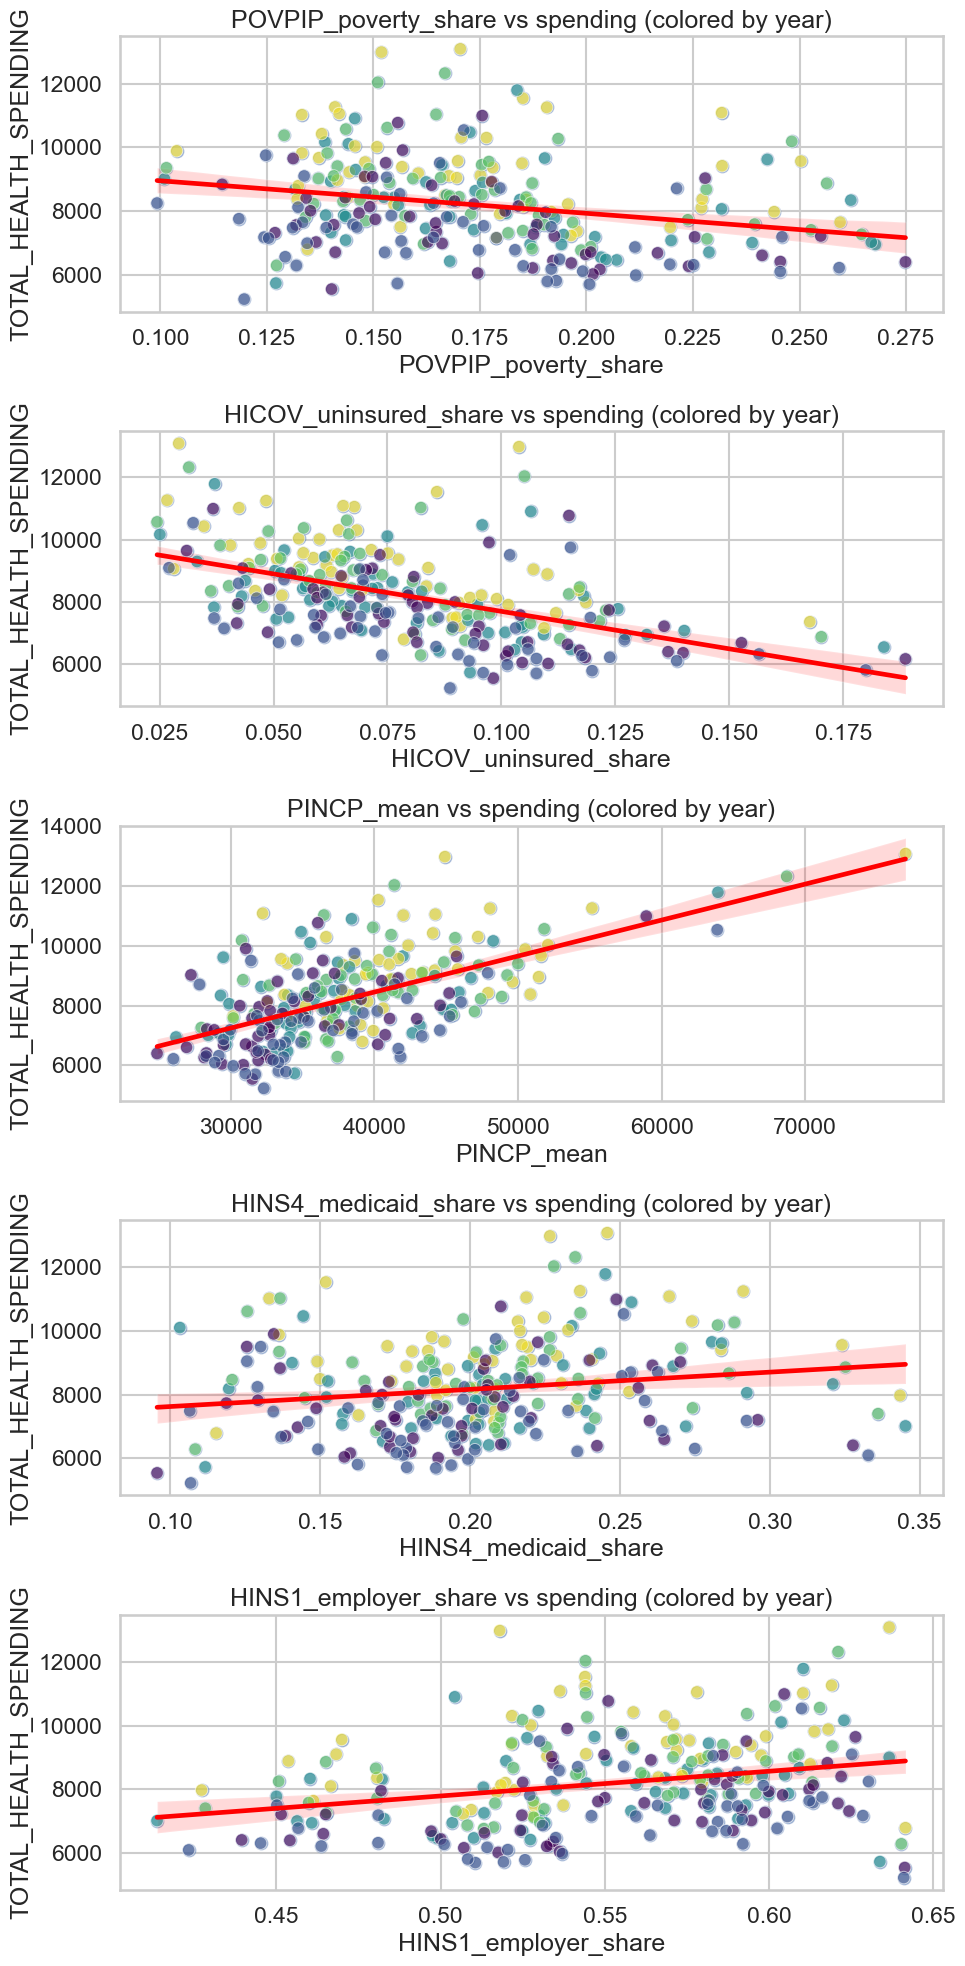

In [125]:
sns.set_theme(style="whitegrid", context="talk")
key_feats = [f for f in ['POVPIP_poverty_share', 'HICOV_uninsured_share', 'PINCP_mean', 'HINS4_medicaid_share', 'HINS1_employer_share'] if f in df_state_year.columns]
if key_feats:
    n = len(key_feats)
    fig, axes = plt.subplots(n, 1, figsize=(10, 4*n), sharex=False)
    if n == 1:
        axes = [axes]
    for ax, feat in zip(axes, key_feats):
        sns.regplot(data=df_state_year, x=feat, y=target, ax=ax, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
        sns.scatterplot(data=df_state_year, x=feat, y=target, hue='YEAR', palette='viridis', ax=ax, legend=False, alpha=0.6)
        ax.set_title(f'{feat} vs spending (colored by year)')
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, title='YEAR', bbox_to_anchor=(1.02, 0.5), loc='center left')
    plt.tight_layout()
    plt.show()
